# Training Environment

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch  # Package name: torch (for pip), pytorch (for conda)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

class BasicDataset(data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __getitem__(self, idx):
        return dict(X=self.X[idx], y=self.y[idx])
    
    def __len__(self):
        return self.X.shape[0]
    
#Some methods for evaluating results
def get_confusion_matrix(y_pred, y_true, n_classes):
    assert len(y_pred) == len(y_true)
    results = np.zeros(shape=(n_classes, n_classes))
    for i in range(len(y_pred)):
        results[y_pred[i], y_true[i]] += 1
    return results
    
def precision(y_pred, y_true, n_classes):
    precision = np.zeros(shape=n_classes)
    confusion_matrix = get_confusion_matrix(y_pred, y_true, n_classes)
    for i in range(n_classes):
        sum_of_row = confusion_matrix[i].sum()
        if confusion_matrix[i, i] != 0:
            precision[i] = confusion_matrix[i, i] / sum_of_row
    return precision

def recall(y_pred, y_true, n_classes):
    recall = np.zeros(shape=n_classes)
    confusion_matrix = get_confusion_matrix(y_pred, y_true, n_classes)
    for i in range(n_classes):
        sum_of_column = confusion_matrix[:,i].sum()
        if confusion_matrix[i, i] != 0:
            recall[i] = confusion_matrix[i, i] / sum_of_column
    return recall

def f1score(y_pred, y_true, n_classes):
    p = precision(y_pred, y_true, n_classes)
    r = recall(y_pred, y_true, n_classes)
    f1 = np.zeros(shape=n_classes)
    for i in range(n_classes):
        if r[i] + p[i] != 0:
            f1[i] = 2 * p[i] * r[i] / (r[i] + p[i])
    return f1

## Prepare Data

In [2]:
import torchvision.datasets as datasets

mnist = False
cifar10 = True
cifar100 = False
assert mnist ^ cifar10 ^ cifar100

n_classes = 10
if mnist:
    trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
    testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)
if cifar10:
    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
    testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=None)
if cifar100:
    n_classes = 100
    trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=None)
    testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=None)

print(trainset)
print(testset)


Extracting ./data\cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Dataset CIFAR100
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
Dataset CIFAR100
    Number of datapoints: 10000
    Root location: ./data
    Split: Test


In [3]:
def to_rgb(x_grey: torch.Tensor) -> torch.Tensor:
    if len(x_grey.size()) == 3:
        helper = torch.unsqueeze(x_grey, 1)
        return helper.repeat(1, 3, 1, 1).float()
    elif len(x_grey.size()) == 4 and x_grey.size()[1] == 1:
        return x_grey.repeat(1, 3, 1, 1).float()
    elif len(x_grey.size()) == 4 and x_grey.size()[1] == 3:
        return x_grey
    elif len(x_grey.size()) == 4:
        raise ValueError(f'The size of this image tensor is not valid.\
        A 4th order image tensor must have dim1==1 (grey-scale) or dim1==3 (rgb).\
        Unknown format cannot be transformed to rgb.')
    else:
        raise ValueError(f'The size of this image-tensor is not valid.\
        Must be either 3rd (grey-scale) order tensor or 4th order tensor (rgb).\
        Got order {len(x_grey.size())}')
        
def swap_data(X):
    X1 = np.swapaxes(X, 1, 3)
    X2 = np.swapaxes(X1, 2, 3)
    return X2

if mnist:
    X_train_grey = trainset.train_data
    X_train = to_rgb(X_train_grey)
    X_test_grey = testset.test_data
    X_test = to_rgb(X_test_grey)
    y_train = trainset.train_labels
    y_test = testset.test_labels
else:
    X_train = torch.tensor(swap_data(trainset.data))
    y_train = torch.tensor(trainset.targets)
    X_test = torch.tensor(swap_data(testset.data))
    y_test = torch.tensor(testset.targets)
    
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: torch.Size([50000, 3, 32, 32])
y_train: torch.Size([50000])
X_test: torch.Size([10000, 3, 32, 32])
y_test: torch.Size([10000])


## Training

In [4]:
from torchvision import models

model = models.resnet18(pretrained=False) # set model here
in_ftr = model.fc.in_features
out_ftr = n_classes
model.fc = nn.Linear(in_ftr,out_ftr,bias=True)
    
dataset_train = BasicDataset(X_train, y_train)
dataset_test = BasicDataset(X_test, y_test)

Check specs for GPU-based training.

In [5]:
print('cuda available:', torch.cuda.is_available())
print('cuda device name:', torch.cuda.get_device_name())
print('cuda device id', torch.cuda.current_device())

cuda available: True
cuda device name: NVIDIA GeForce 940MX
cuda device id 0


Move model and data to GPU.

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
X_train.to(device)
print('worked?', X_train.to(device).is_cuda)

worked? True


In [7]:
def evaluate_model(model, dataset, batch_size=1000):
    
    data_loader = data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False, drop_last=False)
    loss = 0.0
    correct = 0
    
    for batch in data_loader:
        yhat = model.forward(batch['X'].float().to(device))
        y = batch['y'].long().to(device)
        batch_loss = f_loss(yhat, y)
        loss += batch_loss.item() * len(batch['X'])
        correct += (torch.argmax(yhat, dim=1) == y).float().sum().item()
    accuracy = correct / len(dataset)
    
    return loss, accuracy

In [8]:
def train_model(model, dataset, validation_set, base_lr=0.01, max_lr=0.01, batch_size=64, epochs=1, 
                f_opt=optim.SGD, f_loss=F.cross_entropy):
    
    optimizer = f_opt(model.parameters(), lr=base_lr)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr, max_lr)
    lr_history = []
    validation_accuracy = []
    epoch_losses = []
    validation_losses = []
    
    # evaluate initial state of model
    initial_training_loss, _ = evaluate_model(model, dataset)
    epoch_losses.append(initial_training_loss)
    validation_loss, accuracy = evaluate_model(model, validation_set)
    validation_losses.append(validation_loss)
    validation_accuracy.append(accuracy)

    for epoch in range(epochs):
        # training and epoch loss logging
        # drop last to avoid stochastic outliers in gradient update
        data_loader = data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        epoch_loss = 0.0 
        for batch in data_loader:
            model.zero_grad()
            yhat = model.forward(batch['X'].float().to(device))
            batch_loss = f_loss(yhat, batch['y'].long().to(device))
            epoch_loss += batch_loss.item() * len(batch['X'])
            batch_loss.backward()
            optimizer.step()
            scheduler.step()
            lr_history.append(scheduler.get_last_lr())
        print(f'Epoch {epoch+1}/{epochs} - Loss: {epoch_loss / len(dataset)} - LR: {scheduler.get_last_lr()}')
        epoch_losses.append(epoch_loss)
        
        # calculate validation loss and accuracy
        validation_loss, accuracy = evaluate_model(model, validation_set)
        validation_losses.append(validation_loss)
        validation_accuracy.append(accuracy)
        
    return (np.array(epoch_losses) / len(dataset), 
            np.array(validation_losses) / len(validation_set), 
            validation_accuracy, 
            lr_history)

In [9]:
base_lr = 0.01
max_lr = 0.1
batch_size = 512
epochs = 2
f_opt=optim.SGD
f_loss=F.cross_entropy

training_loss, validation_loss, validation_accuracy, lr_history = train_model(model.to(device), dataset_train, dataset_test,
                                                                              base_lr, max_lr, batch_size, epochs,
                                                                              f_opt, f_loss)

C:\Users\robin\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1/2 - Loss: 3.8902488061523437 - LR: [0.01436500000000002]
Epoch 2/2 - Loss: 3.1400494775390624 - LR: [0.018729999999999997]


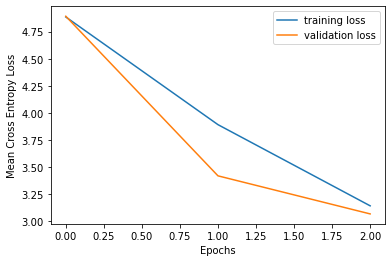

In [10]:
plt.plot(training_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Cross Entropy Loss')
#plt.ylim(0.0, 10)
plt.legend()

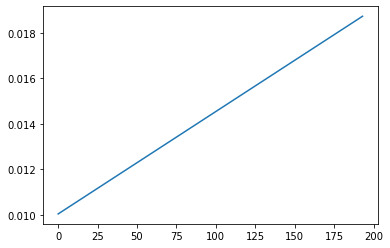

In [11]:
plt.plot(lr_history)

0.2473


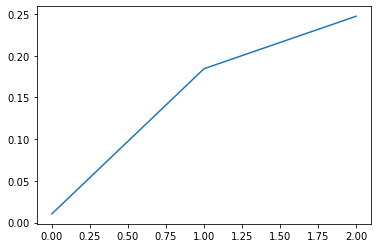

In [14]:
plt.plot(validation_accuracy)
print(max(validation_accuracy))

In [13]:
import csv
from google.colab import files

with open('train_loss', 'w') as f:
    write = csv.writer(f)
    write.writerow(training_loss)

with open('val_loss', 'w') as f: 
    write = csv.writer(f)  
    write.writerow(validation_loss)

with open('val_accuracy', 'w') as f: 
    write = csv.writer(f)  
    write.writerow(validation_accuracy)
    
with open('lr_history', 'w') as f: 
    write = csv.writer(f)  
    write.writerow(lr_history)

files.download('train_loss')
files.download('val_loss')
files.download('val_accuracy')
files.download('lr_history')

ModuleNotFoundError: No module named 'google'